In [1]:
# API key ID: otlwwfxero72fkms03hi49x2
# API key secret: 5qbnpzqphl1y8bz6eggxraxlzlnbnhso49bro4925r1rpxj6sn
# app token: 8y23ArYxg4pcvOMgWzMFSC0nB
# secret app token: pZgwEL4lKm2r1s868Saz3EJ1ebpTKy-FzglU

# crime data docs: https://dev.socrata.com/foundry/data.cityofchicago.org/9hwr-2zxp

# make sure to install these packages before running:
!pip install pandas
!pip install sodapy
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 683 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 350 kB/s 


In [2]:
import pandas as pd
import sodapy
from sodapy import Socrata
import statistics
pd.set_option('display.max_columns', 500)

In [3]:
# crime_url = "https://data.cityofchicago.org/resource/9hwr-2zxp.json"


app_token = "8y23ArYxg4pcvOMgWzMFSC0nB"

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org",
                 app_token, 
                 username="ch35@illinois.edu",
                 password="68M8rz3vF!StBjD")


# First 250000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit = 250000)

# Convert to pandas DataFrame
crime_df = pd.DataFrame.from_records(results)

print(crime_df.shape)

(219787, 22)


# Logistic Regression

In [4]:
crime_df.head()

,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,iucr,x_coordinate,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-12-06T23:55:00.000,"{'latitude': '41.798784161', 'human_address': ...",002,053XX S GREENWOOD AVE,1870121,41.798784161,OVER $500,APARTMENT,2022-12-13T15:48:01.000,41,0810,1184281,5,JF501063,2022,False,06,-87.599727485,0233,THEFT,False,12915642
1,2022-12-06T23:49:00.000,"{'latitude': '41.772681233', 'human_address': ...",007,002XX W MARQUETTE RD,1860536,41.772681233,AGGRAVATED - HANDGUN,STREET,2022-12-13T15:48:01.000,68,051A,1175581,6,JF500895,2022,True,04A,-87.631918784,0722,ASSAULT,False,12914728
2,2022-12-06T23:40:00.000,"{'latitude': '41.878638996', 'human_address': ...",001,002XX S STATE ST,1899156,41.878638996,OVER $500,CTA STATION,2022-12-13T15:48:01.000,32,0810,1176417,42,JF502675,2022,False,06,-87.627691486,0113,THEFT,False,12916296
3,2022-12-06T23:40:00.000,"{'latitude': '41.732098332', 'human_address': ...",022,016XX W 89TH ST,1845677,41.732098332,AUTOMOBILE,STREET,2022-12-13T15:48:01.000,73,0910,1166788,21,JF501133,2022,False,07,-87.664574912,2221,MOTOR VEHICLE THEFT,False,12914907
4,2022-12-06T23:37:00.000,"{'latitude': '41.899415341', 'human_address': ...",015,010XX N LAWLER AVE,1906473,41.899415341,OVER $500,RESIDENCE,2022-12-13T15:48:01.000,25,0810,1142504,37,JF500887,2022,True,06,-87.752031985,1531,THEFT,False,12914748


In [5]:
#creating variable for month
month = [i[0:7] for i in crime_df.date]

In [6]:
#adding to data frame
crime_df["month"] = month

In [7]:
#dropping irrelevant variables
crime_df_clean = crime_df.drop(["date", "location", "block", "updated_on", "case_number", "year", "id"], axis = 1)
crime_df_clean.head()

,district,y_coordinate,latitude,description,location_description,community_area,iucr,x_coordinate,ward,domestic,fbi_code,longitude,beat,primary_type,arrest,month
0,002,1870121,41.798784161,OVER $500,APARTMENT,41,0810,1184281,5,False,06,-87.599727485,0233,THEFT,False,2022-12
1,007,1860536,41.772681233,AGGRAVATED - HANDGUN,STREET,68,051A,1175581,6,True,04A,-87.631918784,0722,ASSAULT,False,2022-12
2,001,1899156,41.878638996,OVER $500,CTA STATION,32,0810,1176417,42,False,06,-87.627691486,0113,THEFT,False,2022-12
3,022,1845677,41.732098332,AUTOMOBILE,STREET,73,0910,1166788,21,False,07,-87.664574912,2221,MOTOR VEHICLE THEFT,False,2022-12
4,015,1906473,41.899415341,OVER $500,RESIDENCE,25,0810,1142504,37,True,06,-87.752031985,1531,THEFT,False,2022-12


## Removing Categorical Variables with High Cardinality (50+ Levels)

In [8]:
crime_df_clean.dtypes

district                object
y_coordinate            object
latitude                object
description             object
location_description    object
community_area          object
iucr                    object
x_coordinate            object
ward                    object
domestic                  bool
fbi_code                object
longitude               object
beat                    object
primary_type            object
arrest                    bool
month                   object
dtype: object

In [9]:
#converting variables to numeric
num_vars = ["y_coordinate", "x_coordinate", "latitude", "longitude"]
for i in num_vars:
    crime_df_clean[i] = crime_df_clean[i].astype("float")
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                   bool
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                     bool
month                    object
dtype: object

In [10]:
#converting boolean variables to binary categorical variables
crime_df_clean["domestic"] = crime_df_clean["domestic"].astype(int)
crime_df_clean["arrest"] = crime_df_clean["arrest"].astype(int)
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                  int64
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                    int64
month                    object
dtype: object

In [11]:
crime_df_clean["arrest"].dtypes == "O"

False

In [12]:
#storing list of cateogorical variables with high cardinality
high_card = [var for var in crime_df_clean.columns if len(crime_df_clean[var].value_counts()) >= 50 and crime_df_clean[var].dtypes == "O"]
high_card

['description',
 'location_description',
 'community_area',
 'iucr',
 'ward',
 'beat']

In [13]:
#dropping from set
crime_df_new = crime_df_clean.drop(high_card, axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,fbi_code,longitude,primary_type,arrest,month
0,002,1870121.0,41.798784,1184281.0,0,06,-87.599727,THEFT,0,2022-12
1,007,1860536.0,41.772681,1175581.0,1,04A,-87.631919,ASSAULT,0,2022-12
2,001,1899156.0,41.878639,1176417.0,0,06,-87.627691,THEFT,0,2022-12
3,022,1845677.0,41.732098,1166788.0,0,07,-87.664575,MOTOR VEHICLE THEFT,0,2022-12
4,015,1906473.0,41.899415,1142504.0,1,06,-87.752032,THEFT,0,2022-12


## Binning Categorical Variables
#### Goal is to group levels together if they share a similar target rate to establish bin credibility (at least 1% of observations in each bin)

In [14]:
cat_vars = [var for var in crime_df_new.columns if crime_df_new[var].dtypes == "O"]
cat_vars

['district', 'fbi_code', 'primary_type', 'month']

In [15]:
#district
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
22,16,0.000,0.000
7,019,0.072,0.051
2,012,0.081,0.060
21,020,0.087,0.021
10,002,0.087,0.049
0,008,0.090,0.062
8,003,0.090,0.050
3,004,0.092,0.059
19,022,0.097,0.032
16,024,0.098,0.035


##### Decision: 16 + 019, 011 + 031, all others can remain on their own

In [16]:
#FBI Code
pd.DataFrame({"FBI Code": crime_df_new["fbi_code"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["fbi_code"] == i]), 3) for i in crime_df_new["fbi_code"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["fbi_code"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["fbi_code"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,FBI Code,Target Rate,Proportion
13,10,0.007,0.010
6,11,0.013,0.054
3,07,0.025,0.087
14,02,0.026,0.007
2,14,0.031,0.115
0,06,0.035,0.231
10,05,0.037,0.032
8,03,0.046,0.038
4,08A,0.056,0.075
15,17,0.056,0.007


##### Decision: Variable incredibly similar to the variable below, we'll drop this one

In [17]:
crime_df_new = crime_df_new.drop(["fbi_code"], axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,arrest,month
0,002,1870121.0,41.798784,1184281.0,0,-87.599727,THEFT,0,2022-12
1,007,1860536.0,41.772681,1175581.0,1,-87.631919,ASSAULT,0,2022-12
2,001,1899156.0,41.878639,1176417.0,0,-87.627691,THEFT,0,2022-12
3,022,1845677.0,41.732098,1166788.0,0,-87.664575,MOTOR VEHICLE THEFT,0,2022-12
4,015,1906473.0,41.899415,1142504.0,1,-87.752032,THEFT,0,2022-12


In [18]:
#Primary Type
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
26,HUMAN TRAFFICKING,0.000,0.000
23,INTIMIDATION,0.012,0.001
5,DECEPTIVE PRACTICE,0.015,0.064
4,MOTOR VEHICLE THEFT,0.025,0.087
13,CRIMINAL SEXUAL ASSAULT,0.026,0.007
2,CRIMINAL DAMAGE,0.031,0.115
0,THEFT,0.035,0.231
9,BURGLARY,0.037,0.032
8,ROBBERY,0.046,0.038
12,OFFENSE INVOLVING CHILDREN,0.051,0.008


##### Decision: Bottom 5, Next 5, Next 7, Next 2, Next 5, Last 7

In [19]:
#Month
pd.DataFrame({"Month": crime_df_new["month"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["month"] == i]), 3) for i in crime_df_new["month"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["month"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["month"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Month,Target Rate,Proportion
5,2022-11,0.087,0.091
0,2022-10,0.092,0.104
11,2022-12,0.094,0.018
3,2022-09,0.103,0.100
1,2022-07,0.104,0.100
2,2022-08,0.105,0.100
9,2022-01,0.111,0.070
4,2022-06,0.118,0.093
7,2022-03,0.122,0.083
8,2022-04,0.130,0.081


##### Decision: Bins good to remain on their own, may consider seasonal binning later

### Implementing Bins

In [20]:
#district
crime_df_new.loc[crime_df_new["district"].isin(["16", "019"]), "district"] = "16/019"
crime_df_new.loc[crime_df_new["district"].isin(["011", "031"]), "district"] = "011/031"

In [21]:
#checking new values
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
7,16/019,0.072,0.051
2,012,0.081,0.060
10,002,0.087,0.049
21,020,0.087,0.021
0,008,0.090,0.062
8,003,0.090,0.050
3,004,0.092,0.059
19,022,0.097,0.032
16,024,0.098,0.035
18,014,0.101,0.034


In [22]:
#Primary Type
crime_df_new.loc[crime_df_new["primary_type"].isin(["HUMAN TRAFFICKING", "INTIMIDATION", "DECEPTIVE PRACTICE", "CRIMINAL SEXUAL ASSAULT", "MOTOR VEHICLE THEFT"]), "primary_type"] = "bin1"
crime_df_new.loc[crime_df_new["primary_type"].isin(["CRIMINAL DAMAGE", "THEFT", "BURGLARY", "STALKING", "ROBBERY"]), "primary_type"] = "bin2"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OFFENSE INVOLVING CHILDREN", "SEX OFFENSE", "ARSON", "KIDNAPPING", "ASSAULT", "BATTERY", "OTHER OFFENSE"]), "primary_type"] = "bin3"
crime_df_new.loc[crime_df_new["primary_type"].isin(["HOMICIDE", "CRIMINAL TRESPASS"]), "primary_type"] = "bin4"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OTHER NARCOTIC VIOLATION", "PUBLIC PEACE VIOLATION", "NON-CRIMINAL", "WEAPONS VIOLATION", "OBSCENITY"]), "primary_type"] = "bin5"
crime_df_new.loc[crime_df_new["primary_type"].isin(["PUBLIC INDECENCY", "GAMBLING", "INTERFERENCE WITH PUBLIC OFFICER", "NARCOTICS", "CONCEALED CARRY LICENSE VIOLATION", "LIQUOR LAW VIOLATION", "PROSTITUTION"]), "primary_type"] = "bin6"


In [23]:
#checking new values
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
2,bin1,0.021,0.158
0,bin2,0.035,0.418
1,bin3,0.125,0.340
5,bin4,0.291,0.021
3,bin5,0.605,0.041
4,bin6,0.949,0.022


## WoE (Weight of Evidence) Coding Categorical Variables
### Converts categoricals to numerics to allow their use in the model

In [24]:
#dropping na values
crime_df_new = crime_df_new.dropna()

In [25]:
#train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(crime_df_new.drop(["arrest"], axis = 1), crime_df_new["arrest"], shuffle=True)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(163716, 8)
(54572, 8)
(163716,)
(54572,)


In [27]:
#making sure overall target rates are the same
print(statistics.mean(y_train.astype(int)))
print(statistics.mean(y_test.astype(int)))

0.11263407363971756
0.11174228542109507


In [28]:
#variables to be woe coded
cat_vars_new = [var for var in crime_df_new if crime_df_new[var].dtypes == "O" or var == "domestic"]
cat_vars_new

['district', 'domestic', 'primary_type', 'month']

In [29]:
import category_encoders as ce

In [30]:
#implementing woe coding
woe = ce.WOEEncoder(cols = cat_vars_new)
woe.fit(X_train, y_train)
train_woe = woe.transform(X_train, y_train)
test_woe = woe.transform(X_test)

In [31]:
train_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
17170,0.481067,1893055.0,41.862295,1157917.0,-0.024774,-87.695786,-1.250802,-0.271749
23410,-0.070008,1878783.0,41.823043,1162169.0,-0.024774,-87.680576,0.126666,-0.271749
16719,-0.107476,1910402.0,41.910007,1152417.0,-0.024774,-87.715517,-1.726604,-0.271749
11527,0.036535,1858468.0,41.767062,1173060.0,-0.024774,-87.641221,-1.726604,-0.271749
185057,0.702260,1897463.0,41.874493,1152798.0,0.105821,-87.714461,0.126666,0.102209


In [32]:
test_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
92764,-0.228936,1937366.0,41.983673,1168086.0,-0.024774,-87.657175,0.126666,-0.073463
76299,0.702260,1899160.0,41.879292,1145450.0,-0.024774,-87.741397,-1.250802,-0.093412
90225,0.135066,1909885.0,41.908646,1149437.0,-0.024774,-87.726478,-1.250802,-0.093412
17352,0.297104,1899564.0,41.880443,1143197.0,0.105821,-87.749659,0.126666,-0.271749
139060,0.702260,1904640.0,41.894231,1150591.0,-0.024774,-87.722376,0.126666,0.229928


## Univariate Screening
#### Generating univariate models to see which are predictive on their own

In [33]:
variables = train_woe.columns
import statsmodels.api as sm
from sklearn import metrics

In [34]:
#getting AUC for each individual variable
AUC = []
count = 0
for i in variables:
    mod = sm.GLM(y_train, train_woe[i], family=sm.families.Binomial()).fit()
    pred = mod.predict(test_woe[i])
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    AUC.append(metrics.auc(fpr, tpr))

In [35]:
#displaying AUCs alongside their predictor
pd.DataFrame({"Predictor": train_woe.columns, "AUC": AUC})

,Predictor,AUC
0,district,0.587714
1,y_coordinate,0.490214
2,latitude,0.490040
3,x_coordinate,0.546618
4,domestic,0.515277
5,longitude,0.453104
6,primary_type,0.813360
7,month,0.548357


### Based on the above results, we will look at 3 models:
#### Full Model
#### Model with all AUCs above .5 (significant features only)
#### Model with only location information

In [36]:
#sets for significant features model
train_woe_2 = train_woe.drop(["longitude", "y_coordinate", "latitude"], axis = 1)
test_woe_2 = test_woe.drop(["longitude", "y_coordinate", "latitude"], axis = 1)

In [37]:
#sets for location features model
train_woe_3 = train_woe.drop(["domestic", "primary_type", "month"], axis = 1)
test_woe_3 = test_woe.drop(["domestic", "primary_type", "month"], axis = 1)

In [38]:
train_woe_2.head()

,district,x_coordinate,domestic,primary_type,month
17170,0.481067,1157917.0,-0.024774,-1.250802,-0.271749
23410,-0.070008,1162169.0,-0.024774,0.126666,-0.271749
16719,-0.107476,1152417.0,-0.024774,-1.726604,-0.271749
11527,0.036535,1173060.0,-0.024774,-1.726604,-0.271749
185057,0.702260,1152798.0,0.105821,0.126666,0.102209


In [39]:
test_woe_2.head()

,district,x_coordinate,domestic,primary_type,month
92764,-0.228936,1168086.0,-0.024774,0.126666,-0.073463
76299,0.702260,1145450.0,-0.024774,-1.250802,-0.093412
90225,0.135066,1149437.0,-0.024774,-1.250802,-0.093412
17352,0.297104,1143197.0,0.105821,0.126666,-0.271749
139060,0.702260,1150591.0,-0.024774,0.126666,0.229928


In [40]:
train_woe_3.head()

,district,y_coordinate,latitude,x_coordinate,longitude
17170,0.481067,1893055.0,41.862295,1157917.0,-87.695786
23410,-0.070008,1878783.0,41.823043,1162169.0,-87.680576
16719,-0.107476,1910402.0,41.910007,1152417.0,-87.715517
11527,0.036535,1858468.0,41.767062,1173060.0,-87.641221
185057,0.702260,1897463.0,41.874493,1152798.0,-87.714461


In [41]:
test_woe_3.head()

,district,y_coordinate,latitude,x_coordinate,longitude
92764,-0.228936,1937366.0,41.983673,1168086.0,-87.657175
76299,0.702260,1899160.0,41.879292,1145450.0,-87.741397
90225,0.135066,1909885.0,41.908646,1149437.0,-87.726478
17352,0.297104,1899564.0,41.880443,1143197.0,-87.749659
139060,0.702260,1904640.0,41.894231,1150591.0,-87.722376


## Constructing Model 1 (Full Model)

In [42]:
mod1 = sm.GLM(y_train, train_woe, family=sm.families.Binomial()).fit()
pred1 = mod1.predict(test_woe)
fpr1, tpr1, thresholds = metrics.roc_curve(y_test, pred1)
metrics.auc(fpr1, tpr1)

0.8289205035553239

### ROC Curve

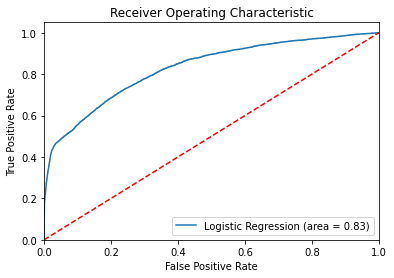

In [43]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % metrics.auc(fpr1, tpr1))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [68]:
pred1_log = round(pred1)
same_count = np.count_nonzero(pred1_log==y_test)
accuracy_1 = same_count/len(pred1)
accuracy_1

0.9167521806054387

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred1_log))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     48474
           1       0.73      0.41      0.52      6098

    accuracy                           0.92     54572
   macro avg       0.83      0.69      0.74     54572
weighted avg       0.91      0.92      0.91     54572



## Constructing Model 2 (Significant AUC Model)

In [45]:
mod2 = sm.GLM(y_train, train_woe_2, family=sm.families.Binomial()).fit()
pred2 = mod2.predict(test_woe_2)
fpr2, tpr2, thresholds = metrics.roc_curve(y_test, pred2)
metrics.auc(fpr2, tpr2)

0.8254880862919579

### ROC Curve

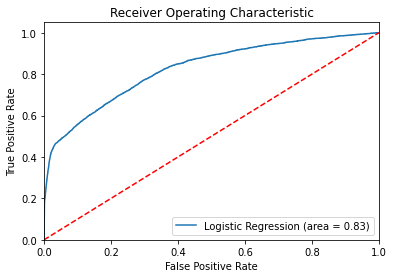

In [46]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr2, tpr2, label='Logistic Regression (area = %0.2f)' % metrics.auc(fpr2, tpr2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [75]:
import numpy as np
pred2_log = round(pred2)
same_count = np.count_nonzero(pred2_log==y_test)
accuracy_2 = same_count/len(pred2)
accuracy_2

0.9168254782672433

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred2_log))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     48474
           1       0.73      0.41      0.52      6098

    accuracy                           0.92     54572
   macro avg       0.83      0.70      0.74     54572
weighted avg       0.91      0.92      0.91     54572



## Constructing Model 3 (Location Model)

In [47]:
mod3 = sm.GLM(y_train, train_woe_3, family=sm.families.Binomial()).fit()
pred3 = mod3.predict(test_woe_3)
fpr3, tpr3, thresholds = metrics.roc_curve(y_test, pred3)
metrics.auc(fpr3, tpr3)

0.5885500364533229

### ROC Curve

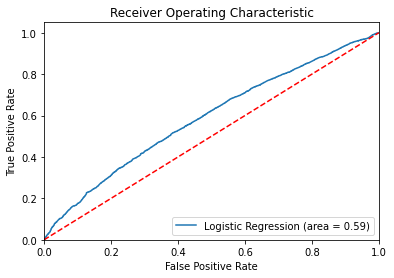

In [48]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr3, tpr3, label='Logistic Regression (area = %0.2f)' % metrics.auc(fpr3, tpr3))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [67]:
pred3_log = round(pred3)
same_count = np.count_nonzero(pred3_log==y_test)
accuracy_3 = same_count/len(pred3)
accuracy_3

0.8882577145789049

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred3_log))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     48474
           1       0.00      0.00      0.00      6098

    accuracy                           0.89     54572
   macro avg       0.44      0.50      0.47     54572
weighted avg       0.79      0.89      0.84     54572



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### From these results, we'd draw that the first 2 models are near equivalent in predictive power yet the second is more parsimonious. Therefore, we decide to choose the second model (signficant features) as our final model.

## Best Model Summary
### (Significant AUC Model)

In [ ]:
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 arrest   No. Observations:               161057
Model:                            GLM   Df Residuals:                   161052
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40677.
Date:                Fri, 09 Dec 2022   Deviance:                       81355.
Time:                        16:03:34   Pearson chi2:                 1.63e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1802
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
district         0.3275      0.032     10.097      0.000       0.264       0.391
x_coordinate -1.781e-06   8.38e-09   -212.460      0.000    -1.8e-06   -1.76e-06
domestic         1.1197      0.154      7.285      0.000       0.818       1.421
primary_type     0.9950      0.007    137.915      0.000       0.981       1.009
month            0.6415      0.057     11.315      0.000       0.530       0.753
================================================================================
"""